In [ ]:
#hello :P

In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


Imports:

In [77]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import sys
import zipfile
from collections import defaultdict
import random
from tqdm import tqdm
from PIL import Image
import glob

#PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms

#roboflow
from roboflow import Roboflow

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Data Pipeline:

In [ ]:
#get datasets from roboflow (they should give us a pastable snippet for api call)

"""
WARNING: data pipeline only works with access to the api_key. 

"""

rf = Roboflow(api_key)
project = rf.workspace("mlproject-v4hpt").project("ml_project_2025-mcrr0")
version = project.version(4)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ML_Project_2025-4 in yolov5pytorch:: 100%|██████████| 21996/21996 [00:05<00:00, 3898.01it/s]


## data validation

(np.float64(-0.5), np.float64(383.5), np.float64(511.5), np.float64(-0.5))

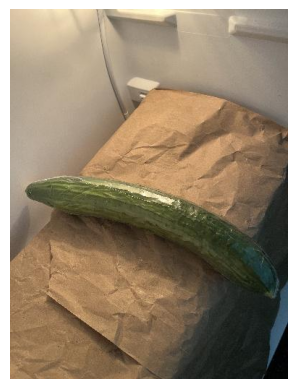

In [45]:
#testing img display
img_path = "/content/ML_Project_2025-4/train/images/IMG_8506_jpg.rf.a8756e1adce3bd3e40a75ea952044c6a.jpg"
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")

In [46]:
#testing img label
#format: <class_id> <x_center> <y_center> <width> <height>
!cat /content/ML_Project_2025-4/train/labels/frame_000015_jpg.rf.147e586577c63ee8890409ddb9ae664f.txt

2 0.30694444444444446 0.4973828125 0.6138888888888889 0.2127265625

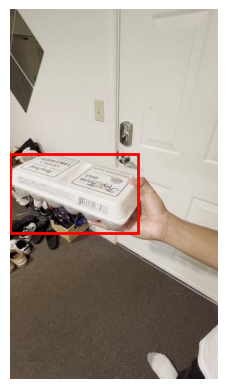

In [47]:
#verify bounding boxes

def plot_yolo_boxes(img_path, label_path):
    img = np.array(Image.open(img_path))
    h, w, _ = img.shape

    plt.imshow(img)

    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.split())

            x1 = (x - bw/2) * w
            y1 = (y - bh/2) * h
            x2 = (x + bw/2) * w
            y2 = (y + bh/2) * h

            plt.gca().add_patch(
                plt.Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor="red",
                    linewidth=2
                )
            )

    plt.axis("off")
    plt.show()

plot_yolo_boxes(
    "/content/ML_Project_2025-4/train/images/frame_000015_jpg.rf.147e586577c63ee8890409ddb9ae664f.jpg",
    "/content/ML_Project_2025-4/train/labels/frame_000015_jpg.rf.147e586577c63ee8890409ddb9ae664f.txt"
)

## data work

Labels/Classes:

In [49]:
CLASSES = [
    "asian pear",
    "cucumber",
    "eggs",
    'hand',
    "leafy green",
    "leftovers",
    "orange",
    "sauce",
    "soda",
    "tomato"
]

num_classes = len(CLASSES)

In [50]:
#label to index mapping
label_to_idx = {label_name: idx for idx, label_name in enumerate(CLASSES)}
idx_to_label = {idx: label_name for label_name, idx in label_to_idx.items()}

In [51]:
print(f"classes: {CLASSES}")
print(f"# of classes: {num_classes}")

classes: ['asian pear', 'cucumber', 'eggs', 'hand', 'leafy green', 'leftovers', 'orange', 'sauce', 'soda', 'tomato']
# of classes: 10


### customize dataset based on roboflow data

In [53]:
#custom dataset class converted from roboflow data format

class RoboflowDataset(Dataset):
    """
    load images from Roboflow format and extract bounding boxes
    """
    def __init__(self, img_dir, label_dir, label_to_idx, transform=None,
                 min_area=100, max_crops_per_image=10):
        """
            img_dir: directory with images
            label_dir: directory with YOLOv5 format labels
            label_to_idx: dictionary mapping class names to indices
            transform: transformations to apply
            min_area: minimum bounding box area to consider
            max_crops_per_image: maximum number of crops to extract per image
        """
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.label_to_idx = label_to_idx
        self.transform = transform
        self.min_area = min_area
        self.max_crops_per_image = max_crops_per_image

        #list of all crops (image_path, bbox, class_id)
        self.samples = []
        self._load_samples()

    def _load_samples(self):
        """all image-bbox-class combinations"""
        img_files = glob.glob(os.path.join(self.img_dir, "*.jpg"))

        print(f"{len(img_files)} images")

        for img_path in tqdm(img_files, desc="loading dataset"):
            #get corresponding label file for image
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(self.label_dir, img_name + ".txt")

            if not os.path.exists(label_path):
                continue

            #read image to get dimensions
            try:
                img = Image.open(img_path)
                img_w, img_h = img.size
            except Exception as e:
                print(f"error loading {img_path}: {e}")
                continue

            #parse YOLOv5 format labels
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue

                    class_id = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:5])

                    #YOLOv5 format (normalized) to pixel coordinates
                    x_center_px = x_center * img_w
                    y_center_px = y_center * img_h
                    w_px = w * img_w
                    h_px = h * img_h

                    #calculate bounding box corners
                    x1 = int(x_center_px - w_px / 2)
                    y1 = int(y_center_px - h_px / 2)
                    x2 = int(x_center_px + w_px / 2)
                    y2 = int(y_center_px + h_px / 2)

                    #ensure bbox is within image bounds
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(img_w, x2)
                    y2 = min(img_h, y2)

                    #check minimum area
                    area = (x2 - x1) * (y2 - y1)
                    if area < self.min_area:
                        continue

                    #add sample to all samples
                    self.samples.append({
                        'img_path': img_path,
                        'bbox': (x1, y1, x2, y2),
                        'class_id': class_id
                    })

        print(f"total samples (crops): {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        #load image
        img = Image.open(sample['img_path']).convert('RGB')

        #crop to bounding box
        x1, y1, x2, y2 = sample['bbox']
        img_crop = img.crop((x1, y1, x2, y2))

        #apply transforms
        if self.transform:
            img_crop = self.transform(img_crop)

        return img_crop, sample['class_id']

In [69]:
#ADD DATA TRANSFORMS BASED ON PAPER (input 32x32), pil image to tensor
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),  #pil to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  #pil to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [70]:
#load data

train_img_dir = '/content/ML_Project_2025-4/train/images'
train_label_dir = '/content/ML_Project_2025-4/train/labels'

val_img_dir = '/content/ML_Project_2025-4/valid/images'
val_label_dir = '/content/ML_Project_2025-4/valid/labels'

test_img_dir = '/content/ML_Project_2025-4/test/images'
test_label_dir = '/content/ML_Project_2025-4/test/labels'

print("\nloading training data")
train_dataset = RoboflowDataset(img_dir=train_img_dir,
                                label_dir=train_label_dir,
                                label_to_idx=label_to_idx,
                                transform=train_transform
)

print("\nloading validation data")
val_dataset = RoboflowDataset(img_dir=val_img_dir,
                              label_dir=val_label_dir,
                              label_to_idx=label_to_idx,
                              transform=val_test_transform
)

print("\nloading testing data")
test_dataset = RoboflowDataset(img_dir=test_img_dir,
                              label_dir=test_label_dir,
                              label_to_idx=label_to_idx,
                              transform=val_test_transform
)

batch_size = 40 #as in the paper
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\ndataset sizes:")
print(f"train: {len(train_dataset)}")
print(f"valid: {len(val_dataset)}")
print(f"test: {len(test_dataset)}")


loading training data
8793 images


loading dataset: 100%|██████████| 8793/8793 [00:01<00:00, 7271.05it/s]


total samples (crops): 8860

loading validation data
1109 images


loading dataset: 100%|██████████| 1109/1109 [00:00<00:00, 5004.36it/s]


total samples (crops): 1109

loading testing data
1090 images


loading dataset: 100%|██████████| 1090/1090 [00:00<00:00, 4513.15it/s]

total samples (crops): 1089

dataset sizes:
train: 8860
valid: 1109
test: 1089


# CNN model

Convolutional Base:

In [66]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        #architecture follows paper

        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 32,
            kernel_size = 4,
            stride = 1,
            padding = 1,
            )

        self.conv2 = nn.Conv2d(
            in_channels = 32,
            out_channels = 128,
            kernel_size = 4,
            stride = 1,
            padding = 1,
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2,
            padding = 0,
        )

        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 4,
            stride = 1,
            padding = 1,
        )

        self.pool2 = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2,
            padding = 0,
        )

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

Model:

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr= 0.0001) #SET LR as per paper
print('\nmodel architecture: ')
print(model)




model architecture: 
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Compile & Train Model:

In [74]:
#training loop

num_epochs = 20 #paper is 250, but reduced bc of project capacity
best_val_acc = 0.0
best_model_path = 'best_model.pth'
train_losses, train_accs, val_losses, val_accs = [], [], [], []

print(f'\ntraining for {num_epochs} epochs')
for epoch in range(num_epochs):
  print(f'epoch {epoch + 1}/{num_epochs}')

  #training
  model.train()

  train_loss_sum = 0.0
  train_correct = 0
  train_total = 0

  for inputs, labels in tqdm(train_loader, desc='training'):
    inputs = inputs.to(device)
    labels = labels.to(device)

    opt.zero_grad()
    #forward pass
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    #backward pass
    loss.backward()
    opt.step()

    #stats
    train_loss_sum += loss.item()
    _, predicted = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss = train_loss_sum / len(train_loader)
  train_losses.append(train_loss)
  train_acc = 100 * train_correct / train_total
  train_accs.append(train_acc)

  #validation
  model.eval()
  val_loss_sum = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='validation'):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      #stats
      val_loss_sum += loss.item()
      _, predicted = torch.max(outputs, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_loss = val_loss_sum / len(val_loader)
  val_losses.append(val_loss)
  val_acc = 100 * val_correct / val_total
  val_accs.append(val_acc)

  print(f'train loss: {train_loss:.4f}, train acc: {train_acc:.2f}%')
  print(f'val loss: {val_loss:.4f}, val acc: {val_acc:.2f}%')

  #save best model
  if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, best_model_path)
        print(f'best model saved with val acc: {best_val_acc:.2f}%')

print(f"training done, best validation accuracy: {best_val_acc:.2f}%")






training for 20 epochs
epoch 1/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


train loss: 0.2153, train acc: 93.53%
val loss: 0.2800, val acc: 94.41%
best model saved with val acc: 94.41%
epoch 2/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


train loss: 0.1890, train acc: 93.96%
val loss: 0.2645, val acc: 93.96%
epoch 3/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


train loss: 0.1617, train acc: 94.82%
val loss: 0.2193, val acc: 95.04%
best model saved with val acc: 95.04%
epoch 4/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


train loss: 0.1408, train acc: 95.51%
val loss: 0.2014, val acc: 95.76%
best model saved with val acc: 95.76%
epoch 5/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


train loss: 0.1318, train acc: 95.86%
val loss: 0.2673, val acc: 93.87%
epoch 6/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


train loss: 0.1287, train acc: 96.30%
val loss: 0.1452, val acc: 95.22%
epoch 7/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


train loss: 0.1048, train acc: 96.79%
val loss: 0.2136, val acc: 95.58%
epoch 8/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


train loss: 0.0961, train acc: 97.01%
val loss: 0.1850, val acc: 96.12%
best model saved with val acc: 96.12%
epoch 9/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


train loss: 0.0940, train acc: 97.10%
val loss: 0.1931, val acc: 96.21%
best model saved with val acc: 96.21%
epoch 10/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


train loss: 0.0827, train acc: 97.40%
val loss: 0.2047, val acc: 95.31%
epoch 11/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


train loss: 0.0823, train acc: 97.57%
val loss: 0.1714, val acc: 96.39%
best model saved with val acc: 96.39%
epoch 12/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


train loss: 0.0730, train acc: 97.97%
val loss: 0.1319, val acc: 95.94%
epoch 13/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


train loss: 0.0760, train acc: 97.91%
val loss: 0.2132, val acc: 97.11%
best model saved with val acc: 97.11%
epoch 14/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


train loss: 0.0654, train acc: 98.23%
val loss: 0.1897, val acc: 96.84%
epoch 15/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


train loss: 0.0579, train acc: 98.31%
val loss: 0.1183, val acc: 96.93%
epoch 16/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


train loss: 0.0603, train acc: 98.19%
val loss: 0.1469, val acc: 96.03%
epoch 17/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


train loss: 0.0511, train acc: 98.53%
val loss: 0.1084, val acc: 97.29%
best model saved with val acc: 97.29%
epoch 18/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


train loss: 0.0573, train acc: 98.31%
val loss: 0.1463, val acc: 97.11%
epoch 19/20


validation: 100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


train loss: 0.0545, train acc: 98.40%
val loss: 0.1064, val acc: 96.84%
epoch 20/20


validation: 100%|██████████| 28/28 [00:09<00:00,  3.05it/s]

train loss: 0.0527, train acc: 98.50%
val loss: 0.1035, val acc: 96.93%
training done, best validation accuracy: 97.29%


model eval

In [75]:
#eval on test set

#load best model
cur_best_model = torch.load(best_model_path)
model.load_state_dict(cur_best_model['model_state_dict'])

model.eval()
test_loss_sum = 0.0
test_correct = 0
test_total = 0

#for confusion matrix
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='testing'):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      #stats
      test_loss_sum += loss.item()
      _, predicted = torch.max(outputs, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

test_loss = test_loss_sum / len(test_loader)
test_acc = 100.0 * test_correct / test_total

print(f'\ntest loss: {test_loss:.4f}')
print(f'test acc: {test_acc:.2f}%')



testing: 100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


test loss: 0.1011
test acc: 97.34%


plots and results

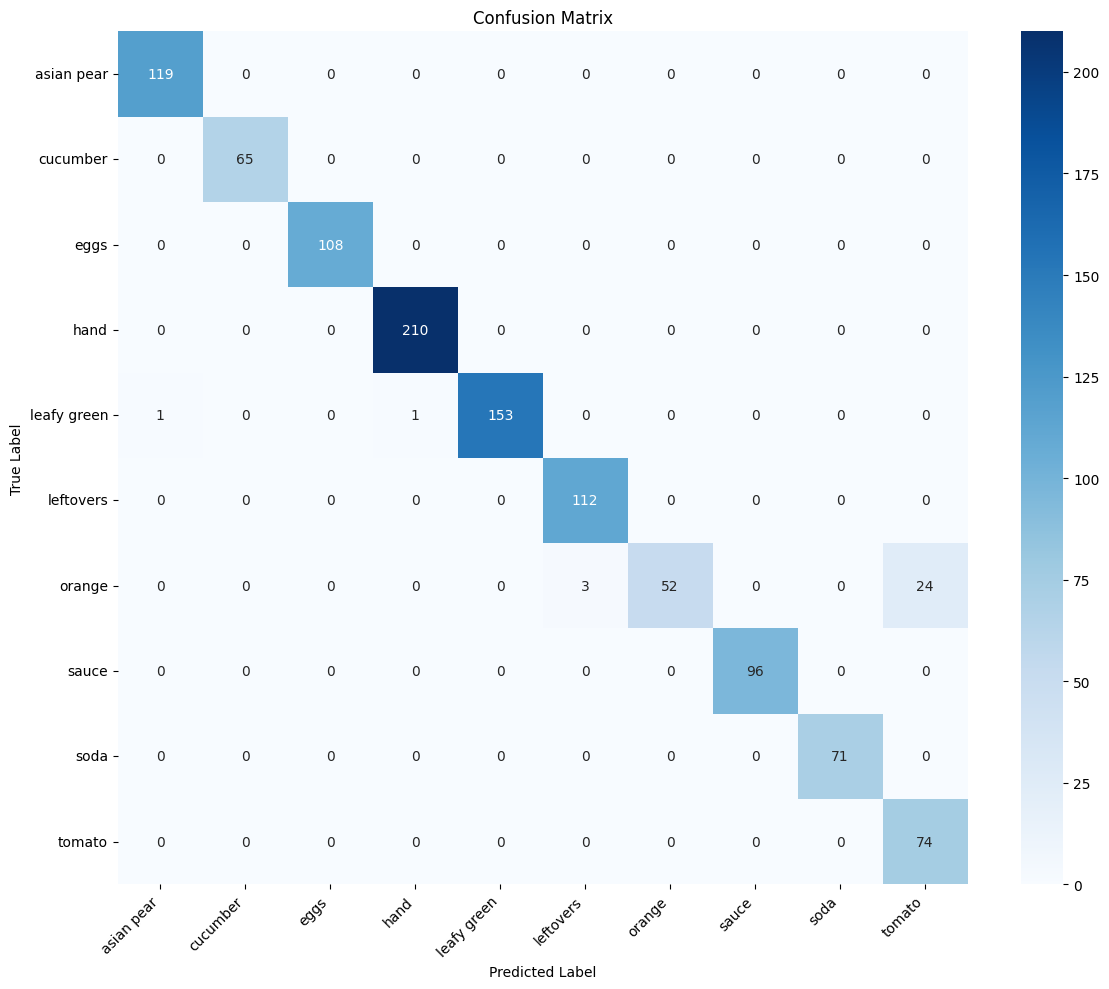

classification report:
              precision    recall  f1-score   support

  asian pear       0.99      1.00      1.00       119
    cucumber       1.00      1.00      1.00        65
        eggs       1.00      1.00      1.00       108
        hand       1.00      1.00      1.00       210
 leafy green       1.00      0.99      0.99       155
   leftovers       0.97      1.00      0.99       112
      orange       1.00      0.66      0.79        79
       sauce       1.00      1.00      1.00        96
        soda       1.00      1.00      1.00        71
      tomato       0.76      1.00      0.86        74

    accuracy                           0.97      1089
   macro avg       0.97      0.96      0.96      1089
weighted avg       0.98      0.97      0.97      1089



In [79]:
#plot confusion matrix

cm = confusion_matrix(all_labels, all_preds)

def plot_cm(cm):
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
  plt.show()

plot_cm(cm)

print('classification report:')
print(classification_report(all_labels, all_preds, target_names=CLASSES))


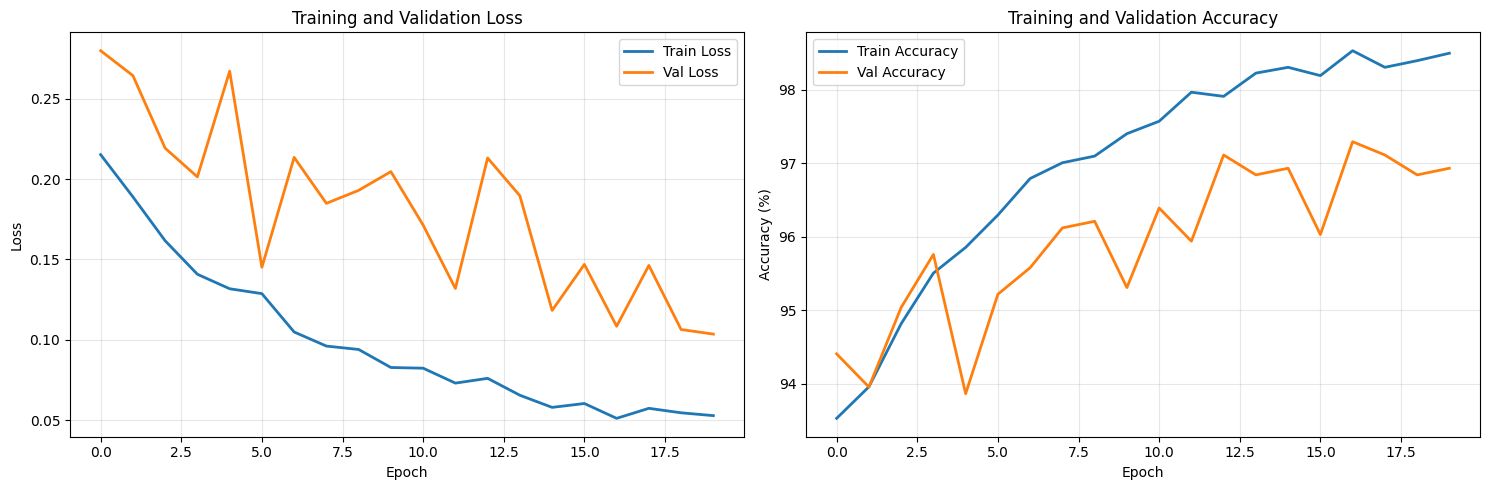

In [81]:
#plot training history

def plot_loss_acc(train_losses, val_losses, train_accs, val_accs):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  #loss plot
  axes[0].plot(train_losses, label='Train Loss', linewidth=2)
  axes[0].plot(val_losses, label='Val Loss', linewidth=2)
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].legend()
  axes[0].grid(True, alpha=0.3)

  #accuracy plot
  axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
  axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy (%)')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].legend()
  axes[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
  plt.show()

plot_loss_acc(train_losses, val_losses, train_accs, val_accs)

In [82]:
#per-class accuracies

class_correct = defaultdict(int)
class_total = defaultdict(int)

for true_label, pred_label in zip(all_labels, all_preds):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

print("\nPer-Class Accuracy:")
print("-" * 40)
for class_idx in range(num_classes):
    if class_total[class_idx] > 0:
        acc = 100.0 * class_correct[class_idx] / class_total[class_idx]
        print(f"{CLASSES[class_idx]:15s}: {acc:6.2f}% ({class_correct[class_idx]}/{class_total[class_idx]})")


Per-Class Accuracy:
----------------------------------------
asian pear     : 100.00% (119/119)
cucumber       : 100.00% (65/65)
eggs           : 100.00% (108/108)
hand           : 100.00% (210/210)
leafy green    :  98.71% (153/155)
leftovers      : 100.00% (112/112)
orange         :  65.82% (52/79)
sauce          : 100.00% (96/96)
soda           : 100.00% (71/71)
tomato         : 100.00% (74/74)


# export model

In [84]:
#save pytorch weights from model in format ready for deployment
torch.save(model.state_dict(), 'fridge_model_weights.pth')
print(f"\nmodel weights saved: fridge_model_weights.pth")

#save complete model
torch.save(model, 'fridge_model_complete.pth')
print("complete model saved: fridge_model_complete.pth")

#save training config
config = {
    'classes': CLASSES,
    'num_classes': num_classes,
    'label_to_idx': label_to_idx,
    'idx_to_label': {str(k): v for k, v in idx_to_label.items()},  #JSON needs string keys
    'input_size': [32, 32],  #list instead of tuple for JSON
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'best_val_acc': float(best_val_acc),
    'test_acc': float(test_acc) if 'test_acc' in locals() else None,
    'architecture': {
        'conv1_out': 32,
        'conv2_out': 128,
        'conv3_out': 256,
        'fc1_out': 512,
        'dropout': 0.5
    }
}

import json
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)
print(f"model config saved to 'model_config.json'")


model weights saved: fridge_model_weights.pth
complete model saved: fridge_model_complete.pth
model config saved to 'model_config.json'
